<a href="https://colab.research.google.com/github/sriksmachi/rbei/blob/yolo_v5/obstacle_detection_for_home_cleaning_robots_yolov5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import os
import json
import argparse
import numpy as np
import random
import math
import csv
import tqdm
import pandas as pd
import skimage.io as io
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import urllib.parse
from shutil import copyfile
from IPython.display import Image, clear_output
from sklearn.model_selection import train_test_split

Connecting to Googl Drive

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Preparation

Let's Define some paths that will be used in this notebook repeatedly. Modify just these paths to match content in your current directory structure and rest of the code need not be changed. 

In [26]:
# This will be the root directory for all other paths used in this project. You can choose any other folder of your choice on your system.
workspace = '/content/drive/MyDrive/rbei/train_data_subsets'
raw_data = workspace + '/syn_images'

# Navigate to the root directory 
%cd '/content/drive/MyDrive/rbei/train_data_subsets'

/content/drive/.shortcut-targets-by-id/11uatbdS26IskCO0FWtW_y78qbDeA2efh/rbei/train_data_subsets


In [27]:
# Create dedicated folder for yolov5 model. It will contain both image dataset and yolov5 model.
if not os.path.exists(workspace + "/yolov5_model/"):
  !mkdir yolov5_model
%cd yolov5_model

/content/drive/.shortcut-targets-by-id/11uatbdS26IskCO0FWtW_y78qbDeA2efh/rbei/train_data_subsets/yolov5_model


In [28]:
# Checking total number of files in the Raw_Data Folder.
len([name for name in os.listdir(raw_data)])

7892

In [29]:
# Loading the training data csv file
filename = os.path.join(raw_data,'training_data.csv')
ds = pd.read_csv(filename)
ds.head()

,image,xmin,ymin,xmax,ymax,label,w,h,x_center,y_center
0,video-5-ezgif-frame-021(10).jpg,2.646451,0.0,638.676775,549.788603,door,636.030324,549.788603,320.661613,274.894302
1,video-5-ezgif-frame-021(101).jpg,125.265334,0.0,1117.684356,596.553309,door,992.419022,596.553309,621.474845,298.276654
2,video-5-ezgif-frame-021(1).jpg,188.780152,0.0,680.137836,450.965074,door,491.357684,450.965074,434.458994,225.482537
3,video-5-ezgif-frame-021(100).jpg,100.565128,0.0,1099.159201,598.318015,door,998.594073,598.318015,599.862164,299.159007
4,video-5-ezgif-frame-021(102).jpg,159.669194,0.0,1118.566506,626.553309,door,958.897312,626.553309,639.117850,313.276654


In [30]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13002 entries, 0 to 13001
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     13002 non-null  object 
 1   xmin      13002 non-null  float64
 2   ymin      13002 non-null  float64
 3   xmax      13002 non-null  float64
 4   ymax      13002 non-null  float64
 5   label     13002 non-null  object 
 6   w         13002 non-null  float64
 7   h         13002 non-null  float64
 8   x_center  13002 non-null  float64
 9   y_center  13002 non-null  float64
dtypes: float64(8), object(2)
memory usage: 1015.9+ KB


In [31]:
# Validate if every Image is atleast tagged once. This cell should not spit any images
count = 0 
filescount = 0
for file in os.listdir(raw_data):
  filescount += 1
  if len(ds[(ds.image==file)]) == 0:
    print(f'file name...{file}')
    count += 1
print(f'{filescount} files found, {count} files untagged')
# filescount

file name...training_data.csv
file name...train_data.xlsx
file name...test-export.csv
file name...train_data.csv
file name...sk_raw-export.csv
file name...syn_images
file name...workspace
file name...bosch_model
file name...rebi-export.csv
file name...doors_tagging-export.csv
7892 files found, 10 files untagged


In [32]:
ds.label.unique()

array(['door', 'furniture', 'cable', 'garment'], dtype=object)

In [33]:
# Normalize
from urllib.parse import unquote
img_w, img_h, num_channels = (1280, 720, 3)
df = ds.copy()
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: str(x).split('.')[0])
df['classes'] = 0
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h
df.head()

,image_id,xmin,ymin,xmax,ymax,label,w,h,x_center,y_center,classes
0,video-5-ezgif-frame-021(10),2.646451,0.0,638.676775,549.788603,door,0.496899,0.763595,0.250517,0.381798,0
1,video-5-ezgif-frame-021(101),125.265334,0.0,1117.684356,596.553309,door,0.775327,0.828546,0.485527,0.414273,0
2,video-5-ezgif-frame-021(1),188.780152,0.0,680.137836,450.965074,door,0.383873,0.626340,0.339421,0.313170,0
3,video-5-ezgif-frame-021(100),100.565128,0.0,1099.159201,598.318015,door,0.780152,0.830997,0.468642,0.415499,0
4,video-5-ezgif-frame-021(102),159.669194,0.0,1118.566506,626.553309,door,0.749139,0.870213,0.499311,0.435106,0


In [34]:
# Encode Labels
df.loc[ds.label == 'door', 'classes'] = 0
df.loc[ds.label == 'furniture', 'classes'] = 1
df.loc[ds.label == 'cable', 'classes'] = 2
df.loc[ds.label == 'garment', 'classes'] = 3
df.classes.unique()

array([0, 1, 2, 3])

furniture    3560
cable        3203
garment      3200
door         3039
Name: label, dtype: int64


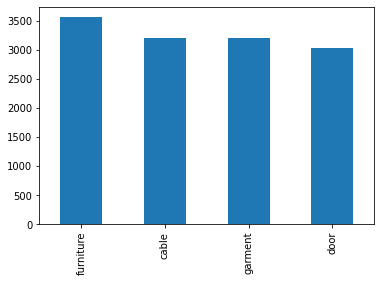

In [35]:
# check class counts
print(df.label.value_counts())
df.label.value_counts().plot(kind='bar');

(720, 1280, 3)

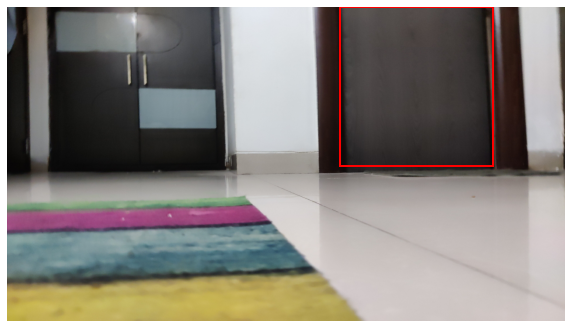

In [36]:
# Plot and check
plt.figure(figsize=(10, 8))
I = io.imread(raw_data + '/IMG_1621346939967.jpg')
foreground = I.copy()
plt.axis('off')
plt.imshow(foreground)
# x, y , w, h
plt.gca().add_patch(Rectangle((764,0),0.273*1280,0.506*720,linewidth=2,edgecolor='r',facecolor='none'))
plt.plot()
foreground.shape

### Preparing Training Environment

In [37]:
!pwd

/content/drive/.shortcut-targets-by-id/11uatbdS26IskCO0FWtW_y78qbDeA2efh/rbei/train_data_subsets/yolov5_model


Clone repo, install dependencies and check PyTorch and GPU.

In [38]:
# Cloning YOLO V5 repo of Ultralytics
if not os.path.exists(os.path.join(workspace, 'yolov5_model', 'yolov5')):
  !git clone https://github.com/ultralytics/yolov5  # clone repo
  
%cd yolov5
%pip install -qr requirements.txt  # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.8.1+cu101 (CPU)


In [39]:
os.getcwd()

'/content/drive/.shortcut-targets-by-id/11uatbdS26IskCO0FWtW_y78qbDeA2efh/rbei/train_data_subsets/yolov5_model/yolov5'

In [40]:
# Creating folder Structure for image dataset, which complies with yolov5 model
if os.getcwd() == workspace + 'yolov5_model/yolov5':
  %cd ..

!mkdir dataset
!mkdir dataset/images
!mkdir dataset/labels
!mkdir dataset/images/train
!mkdir dataset/images/val
!mkdir dataset/labels/train
!mkdir dataset/labels/val

mkdir: cannot create directory ‘dataset’: File exists
mkdir: cannot create directory ‘dataset/images’: File exists
mkdir: cannot create directory ‘dataset/labels’: File exists
mkdir: cannot create directory ‘dataset/images/train’: File exists
mkdir: cannot create directory ‘dataset/images/val’: File exists
mkdir: cannot create directory ‘dataset/labels/train’: File exists
mkdir: cannot create directory ‘dataset/labels/val’: File exists


## Dataset Preparation

In [19]:
df_train, df_val = train_test_split(df, test_size = 0.1, shuffle=True, random_state=42) # Using 90% : 10% Train Test split

In [20]:
# Initialize variables and workspace root
training_data = '/train/'
validation_data = '/val/'
dataset_str = 'dataset'
current = '.'

In [21]:
# Split the data into train and validation folders, and creating corresponding txt files which contain the class, bounding box data per bounding box
from tqdm.auto import tqdm
import shutil as sh

def process_data(df, df_type = 'train'):
  for name,mini in tqdm(df.groupby('image_id')):
    labelPath = dataset_str + '/labels/{}/'.format(df_type)
    imagePath = dataset_str + '/images/{}/'.format(df_type)

    if not os.path.exists(labelPath + name + ".txt"):
      with open(labelPath + name + ".txt", 'w+') as f:
          row = mini[['classes', 'x_center','y_center','w','h']].astype(str).values
          row = row.astype(str)
          for j in range(len(row)):
              text = ' '.join(row[j])
              f.write(text)
              f.write("\n")
      sh.copy("{}/{}.jpg".format(raw_data,name), imagePath + '{}.jpg'.format(name))

In [ ]:
process_data(df_train, 'train')
process_data(df_val, 'val')

In [25]:
# Creating data.yaml file
if not os.path.exists("rbei.yaml"):
  with open("rbei.yaml", 'w+') as f:
    f.write("train: ../dataset/images/train/\n")
    f.write("val: ../dataset/images/val/\n")
    f.write("nc: 4\n")
    f.write("names: ['door', 'furniture', 'cable', 'garment']\n")

In [23]:
!pwd

/content/drive/.shortcut-targets-by-id/11uatbdS26IskCO0FWtW_y78qbDeA2efh/rbei/train_data_subsets/yolov5_model/yolov5


In [26]:
%cd yolov5_model

[Errno 2] No such file or directory: 'yolov5_model'
/content/drive/.shortcut-targets-by-id/11uatbdS26IskCO0FWtW_y78qbDeA2efh/rbei/train_data_subsets/yolov5_model


In [27]:
%cd yolov5

/content/drive/.shortcut-targets-by-id/11uatbdS26IskCO0FWtW_y78qbDeA2efh/rbei/train_data_subsets/yolov5_model/yolov5


### YOLO V5 Small - Training

In [ ]:
# Tensorboard  (optional)
%load_ext tensorboard
%tensorboard --logdir runs/train

In [ ]:
# Weights & Biases  (optional)
%pip install -q wandb
import wandb
wandb.login()

The below command with train the model. The image size takes in the biggest of the two dimensions of the image. --rect indicates that we wish to train our model on rectangle shaped images. Weights can be specified as one of the following values. The code will automatically download the coresponding weights from YOLO V5 official release repository. 
- yolov5s.pt (small model)
- yolov5m.pt (medium model)
- yolov5l.pt (Large Model)
- yolov5x.pt (Extra large Model)


In [ ]:
!python train.py --img-size 1280 --rect --batch 16 --epochs 50 --data ../rbei.yaml --weights yolov5s.pt

github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-177-g5c32bd3 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=16, bbox_interval=-1, bucket='', cache_images=False, cfg='', data='../rbei.yaml', device='', entity=None, epochs=50, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[1280, 1280], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=True, resume=False, save_dir='runs/train/exp7', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=16, upload_dataset=False, weights='yolov5s.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
2021-06-11 07:56:29.775497: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynami

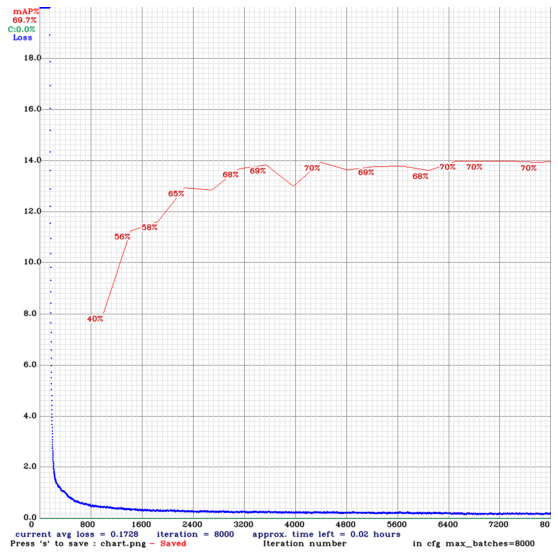

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def imShow(path):
  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)
  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

imShow('chart_yolov4-tiny-custom.png')

#### Predictions